# LightGBM vs XGBoost (sklearn API)
**Disclaimer:** The purpose of the kernel is to illustrate usage of both XGBoost and LightGBM and to compare their performance on the toy data set. Thus, there will be no exploratory data analysis (EDA) or feature engineering. We will do a basic data cleaning to drop missing values and to impute Age and that is it. You are invited to extend this quick analysis with more data features. One can find many excellent kernels explaining how to do it. 

### You have most likely heard many times that XGBoost and LightGBM are trandy buzz words. Let's get some experience with them and compare their performance!

### Import relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import pickle

### Load the data and do minimal visualisation

In [2]:
train = pd.read_csv('~/.kaggle/competitions/titanic/train.csv')

Let's look what is the structure of our data

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's do some basic data manipulations see other kernels, e.g. [this one](https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy/notebook), for examples of how to do it more systematically and clearly.

Fisrt, check for missing values

Text(0.5,1,'Train')

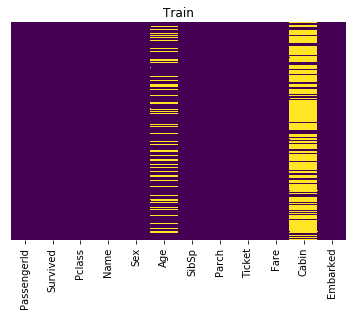

In [4]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Train')

`Cabin` column in categorical and hass too many missing values, so we intend to drop it.
The `Age` column is not hopeless (and maybe children had higher chance to survive?), thus let's impute missing values.

Note, that **doing it on full training sample is WRONG**, although you will see it being done in many other examples. The problem is that we intend to use a sub-sample of `train` to evaluate performance of model, that we are going to build. And imuting mean or any other data-based quantity leads to a data leakage, thus **biased performance estimate**. The same argument applies if one intends to use cross validation  instead of a single train/test split. In the case of cross validation one would need to do imutation independently for each split.

In [5]:
age_mean = train['Age'].mean()
train.fillna(age_mean, inplace=True)

What happened to the missing values?

Text(0.5,1,'Train')

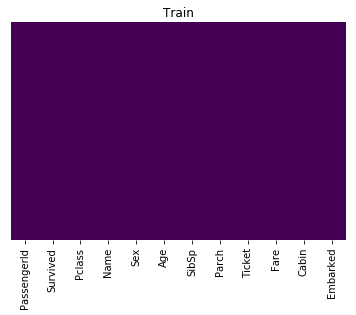

In [6]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Train')

Note, we drop one of columns generated by one-hot encoding, as it is redundant.

In [7]:
# Add one-hot encoding for the Sex, as we know that women were more likely to survive than men
sex_cats_dummies    = pd.get_dummies(train['Sex'], prefix='Sex', drop_first=True) 

# Add dummies for Pclass as well, as it is a category, although stored as an int
pclass_cats_dummies = pd.get_dummies(train['Pclass'], prefix='Pclass', drop_first=True)

# Add one-hot-encoded features to the main dataset
train = pd.concat([train, sex_cats_dummies, pclass_cats_dummies], axis=1)

# Drop categorical columns. Feel free to extract more information from those before droping
train.drop(['Sex','Embarked','Name','Ticket', 'Pclass', 'PassengerId', 'Cabin'], axis=1, inplace=True)

What is the structure after preprocessing?

In [8]:
train.head()

,Survived,Age,SibSp,Parch,Fare,Sex_male,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0
2,1,26.0,0,0,7.9250,0,0,1
3,1,35.0,1,0,53.1000,0,0,0
4,0,35.0,0,0,8.0500,1,0,1


### Which variables have the strongest correlation with the target variable ('Survived')?

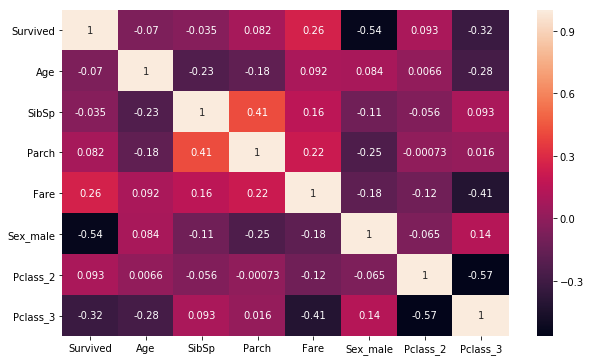

In [9]:
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(), annot=True)

It  seems that the gender and, `Sex`, the social-economic class, `Pclass`, have the strongest correlation with the survival rate

# Simple Train/Test evaluation

Let's split the data into a simple train/test split

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.20, 
                                                    random_state=314)

In [11]:
# Added to suppress warnings from model fiting of type
# DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. 
import warnings
warnings.filterwarnings('ignore', 'The truth value of an empty array is ambiguous. .*')

Let's import `lighgbm` and `xgboost` packages as well as functions that we will need to evaluate accuracy.

In [12]:
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import cross_validate

Now it is time to define several models. Note, that we will use the sklearn interface provided together with each of those tools. This allows one you use them identically to many algorithms implemented in `sklearn` itself. And to profit from the large ecosystem of handy tools inside sklearn.

In [13]:
# Let's define several simple randomly-picked LighGBM and XGBoost models.
models = {'XGB_depth3':  xgb.XGBClassifier(max_depth=3, random_state=314, seed=314, silent=True),
          'XGB_depth5':  xgb.XGBClassifier(max_depth=5, random_state=314, seed=314, silent=True),
          'XGB_depth7':  xgb.XGBClassifier(max_depth=7, random_state=314, seed=314, silent=True),
          'XGB_depth7_regularised':  xgb.XGBClassifier(max_depth=7, colsample_bytree= 0.90, reg_lambda= 1, subsample= 0.80, random_state=314, seed=314, silent=True),
          'LGB_depthINFleaves7': lgb.LGBMClassifier(max_depth=-1, num_leaves=7, random_state=314),
          'LGB_depthINFleaves20': lgb.LGBMClassifier(max_depth=-1, num_leaves=7, ran20om_state=314),
          'LGB_depth3':   lgb.LGBMClassifier(max_depth=3, random_state=314),
          'LGB_depth5':  lgb.LGBMClassifier(max_depth=5, random_state=314)}

Define helper functions that will do fitting and plotting

In [14]:
# These will be pandas.DataFrame's to store the final performance values for plotting
acc_valid_summary = pd.DataFrame(index=sorted(models.keys()), columns=['raw'], dtype=np.float32)
acc_train_summary = pd.DataFrame(index=sorted(models.keys()), columns=['raw'], dtype=np.float32)
fit_time_summary  = pd.DataFrame(index=sorted(models.keys()), columns=['raw'], dtype=np.float32)


def benchmarkModels(models_dict, transform_name='raw'):
    '''
    The function is used to evaluate performance of each algorithm
    
    Parameters
    ----------
    models_dict: dictionary 
        A dictionary of models for evaluation. 
        The items are name string and sklearn-like classifier pairs
    trasform_name: string
        Not used in this example, but allows one to evaluate performance on different data transformations
    '''
    for clf_name, clf in models_dict.items():
        clf.fit(X_train, y_train)
        acc_valid_summary.loc[clf_name, transform_name] = accuracy_score(y_test, clf.predict(X_test))
        acc_train_summary.loc[clf_name, transform_name] = accuracy_score(y_train, clf.predict(X_train))

In [15]:
def plotPerformance(perf_valid, perf_test, perf_fit_time=None, suff=''):
    n_plots = 3 if isinstance(perf_fit_time, pd.DataFrame) else 2
    #create a figure with 2 or subplots
    fig, ax = plt.subplots(ncols=n_plots, figsize=(12,6))
    # increase the white space to fil it long Y axis labels
    fig.subplots_adjust(wspace=1.25)
    
    # The comparison of the two tells us about amount of overtraining
    # performance of the VALIDATION sample 
    sns.heatmap(perf_valid, cmap='Blues', annot=True, vmin=0.75, vmax=0.9, ax=ax[0])
    ax[0].set_title('Accuracy on VALIDATION sample ' + suff)
    # performance of the TRAINING sample 
    sns.heatmap(perf_test, cmap='Blues', annot=True, vmin=0.75, vmax=0.9, ax=ax[1])
    ax[1].set_title('Accuracy on TRAIN sample ' + suff)
    # Plot also trainign time, if provided
    if len(ax) > 2:
        sns.heatmap(perf_fit_time, cmap='Blues', annot=True, ax=ax[2])
        ax[2].set_title('Training time ' + suff)

In [16]:
benchmarkModels(models)

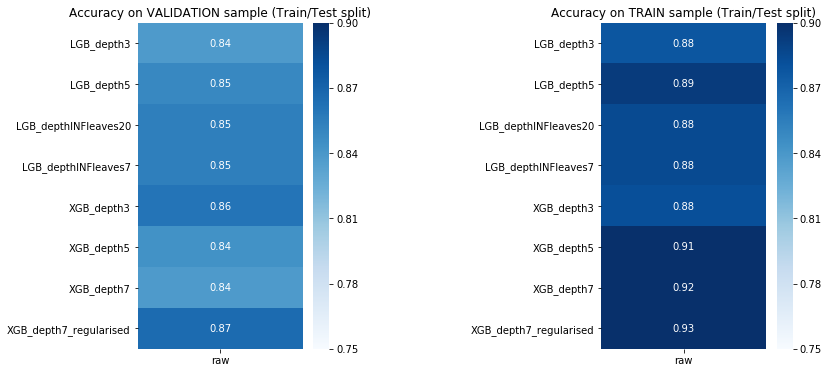

In [17]:
plotPerformance(acc_valid_summary, acc_train_summary, suff='(Train/Test split)')

# Advanced evaluation based on cross validation
Usage of cross validation requires building a pipeline and redoing any data transforms on the unprocessed features. If one tries it on the stored features, then one sees strange effects, when results for all transformed data are the same. This is due to data leakage- transformers were trained on the train sub-sample and thus they leak info about left-out folds. This topic is not illustrated in the current example, but will be added as a separate kernel in the future

In [18]:
acc_valid_cv_summary = pd.DataFrame(index=sorted(models.keys()), columns=['raw'], dtype=np.float32)
acc_train_cv_summary = pd.DataFrame(index=sorted(models.keys()), columns=['raw'], dtype=np.float32)
fit_time_cv_summary  = pd.DataFrame(index=sorted(models.keys()), columns=['raw'], dtype=np.float32)

def benchmarkModelsCV(models_dict, transform_name='raw'):
    for clf_name, clf in models_dict.items():
        # Let's run cross validation on the classifier
        # Note, that  we run it on the full train+test sample:
        # this increases statistics and we do not need the test sample
        score = cross_validate(clf,
                               X = train.drop('Survived', axis=1),
                               y = train['Survived'],
                               scoring=make_scorer(accuracy_score, greater_is_better=True),
                               cv=5, 
                               return_train_score=True)
        # save evaluated performance results
        acc_valid_cv_summary.loc[clf_name, transform_name] = score['test_score'].mean()
        acc_train_cv_summary.loc[clf_name, transform_name] = score['train_score'].mean()
        fit_time_cv_summary.loc[clf_name, transform_name] = score['fit_time'].mean()


In [19]:
benchmarkModelsCV(models)

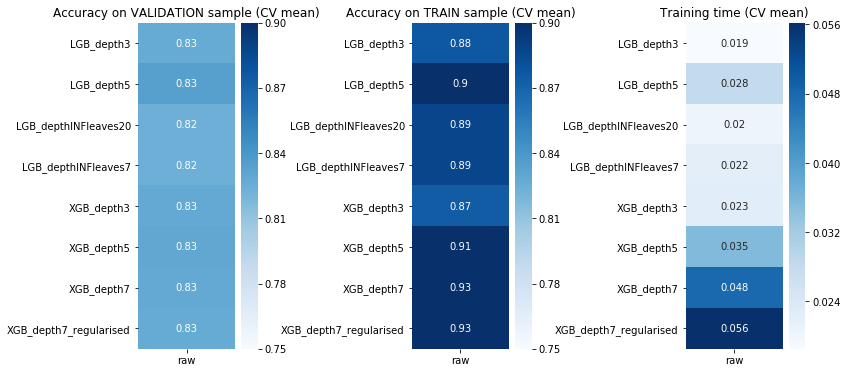

In [20]:
plotPerformance(acc_valid_cv_summary, acc_train_cv_summary, perf_fit_time=fit_time_cv_summary, suff='(CV mean)')